##**TASK - 3: END-TO-END DATA SCIENCE PROJECT**

This project will predict traffic volume on the Metro Interstate based on weather and time features.

Structure of the project:

Data Exploration & Preprocessing

Feature Engineering

Model Development

Model Evaluation

API Development with Flask

Deployment



Refrences and study materials used:https://www.freecodecamp.org/news/end-to-end-machine-learning-project-turorial/
https://github.com/akshu250103/END-TO-END-DATA-SCIENCE-PROJECT/blob/main/Task3.py
https://www.dataquest.io/blog/data-science-projects-for-beginners-with-source-code/#project3
https://github.com/dataquestio/solutions/blob/master/Mission524Solutions.ipynb
https://www.fullstackpython.com/wsgi-servers.html

**1. Data Exploration & Preprocessing**

Initial data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None

Missing values:
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic

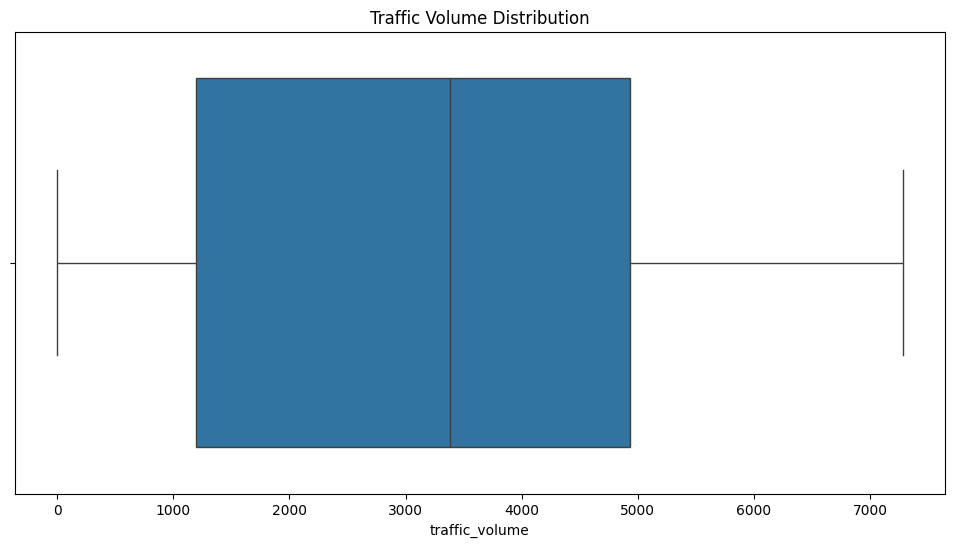

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# Explore the data
print("Initial data info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Convert date_time to datetime and extract features
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Handle holidays
df['is_holiday'] = df['holiday'].apply(lambda x: 1 if x != 'None' else 0)

# Convert temperature from Kelvin to Celsius
df['temp'] = df['temp'] - 273.15

# One-hot encode weather_main
weather_dummies = pd.get_dummies(df['weather_main'], prefix='weather')
df = pd.concat([df, weather_dummies], axis=1)

# Drop unnecessary columns
df.drop(['holiday', 'weather_main', 'weather_description', 'date_time'], axis=1, inplace=True)

# Check for outliers
plt.figure(figsize=(12,6))
sns.boxplot(x=df['traffic_volume'])
plt.title('Traffic Volume Distribution')
plt.show()

# Remove extreme outliers (optional)
q1 = df['traffic_volume'].quantile(0.01)
q99 = df['traffic_volume'].quantile(0.99)
df = df[(df['traffic_volume'] > q1) & (df['traffic_volume'] < q99)]

**2. Feature Engineering**


Missing values after feature engineering:
temp                     0
rain_1h                  0
snow_1h                  0
clouds_all               0
traffic_volume           0
hour                     0
day_of_week              0
month                    0
is_weekend               0
is_holiday               0
weather_Clear            0
weather_Clouds           0
weather_Drizzle          0
weather_Fog              0
weather_Haze             0
weather_Mist             0
weather_Rain             0
weather_Smoke            0
weather_Snow             0
weather_Squall           0
weather_Thunderstorm     0
time_evening_peak        0
time_midday              0
time_morning_peak        0
time_night               0
weather_severity        24
dtype: int64

Missing values after cleaning:
0


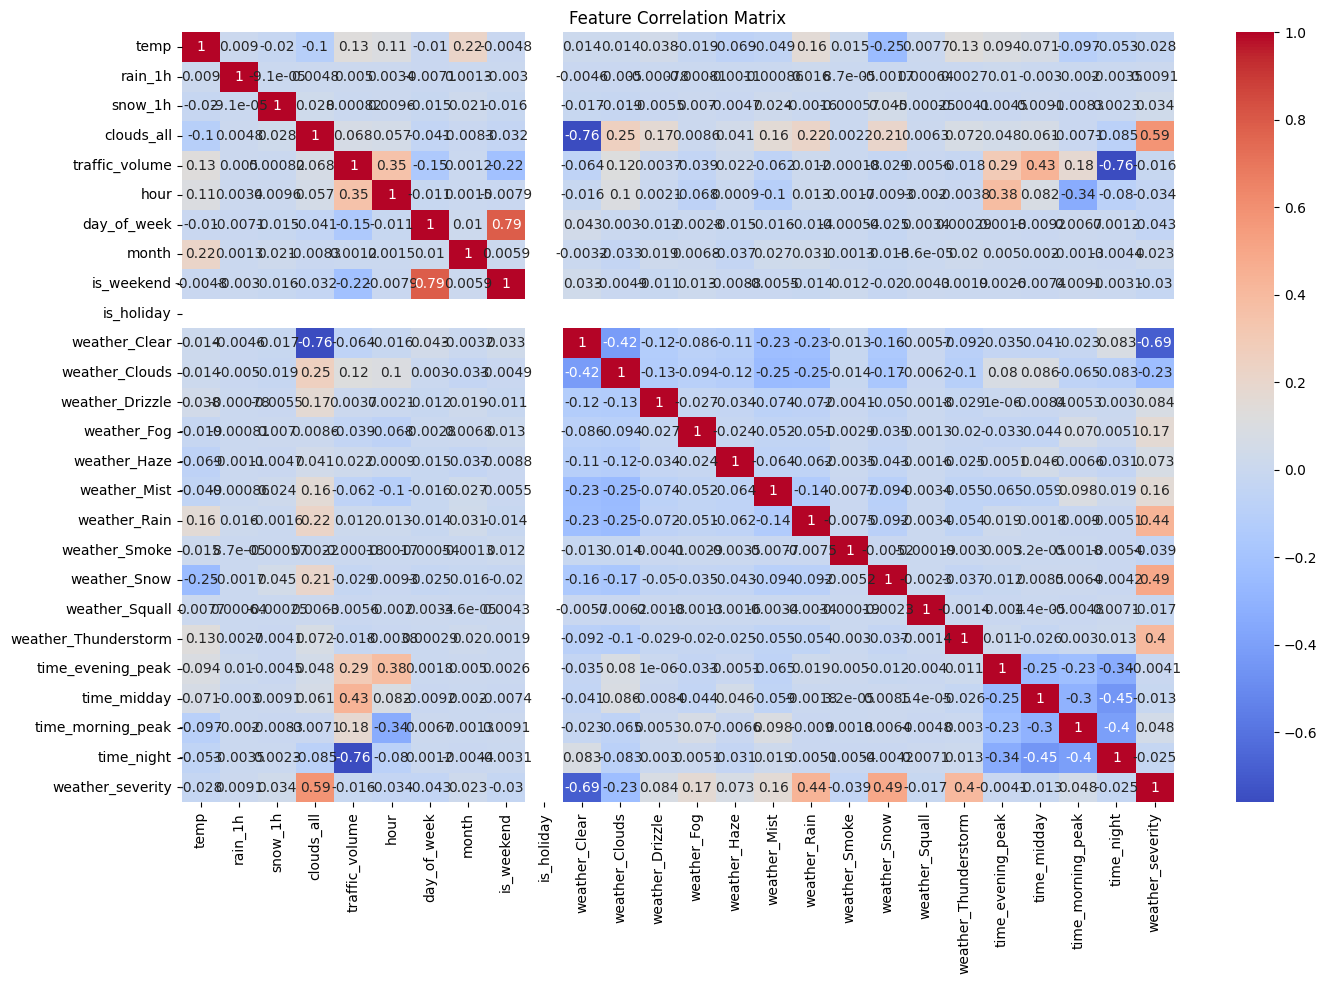

In [ ]:
# Create time-based features
def get_time_of_day(hour):
    if 5 <= hour < 10:
        return 'morning_peak'
    elif 10 <= hour < 16:
        return 'midday'
    elif 16 <= hour < 20:
        return 'evening_peak'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)
time_dummies = pd.get_dummies(df['time_of_day'], prefix='time')
df = pd.concat([df, time_dummies], axis=1)

# Create weather severity feature
weather_severity = {
    'Clear': 1,
    'Clouds': 2,
    'Drizzle': 3,
    'Rain': 4,
    'Snow': 5,
    'Thunderstorm': 6,
    'Mist': 3,
    'Haze': 3,
    'Fog': 4
}

# Map the original weather_main to severity
weather_cols = [col for col in df.columns if col.startswith('weather_')]
df['weather_main'] = df[weather_cols].idxmax(axis=1).str.replace('weather_', '')
df['weather_severity'] = df['weather_main'].map(weather_severity)

# Drop intermediate columns
df.drop(['time_of_day', 'weather_main'], axis=1, inplace=True)

# Handle any remaining NaN values
print("\nMissing values after feature engineering:")
print(df.isnull().sum())

# Fill any remaining NaN values (shouldn't be any with this dataset, but just in case)
df.fillna(0, inplace=True)

# Verify no NaN values remain
print("\nMissing values after cleaning:")
print(df.isnull().sum().sum())  # Should be 0

# Check correlation
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

**3. Model Development**

NaN values in X_train: 0
NaN values in y_train: 0

Random Forest Performance:
MAE: 249.64
MSE: 183617.71
RMSE: 428.51
R2: 0.95

Gradient Boosting Performance:
MAE: 327.46
MSE: 246843.00
RMSE: 496.83
R2: 0.93

Linear Regression Performance:
MAE: 799.69
MSE: 1063311.85
RMSE: 1031.17
R2: 0.72

Best model: Random Forest


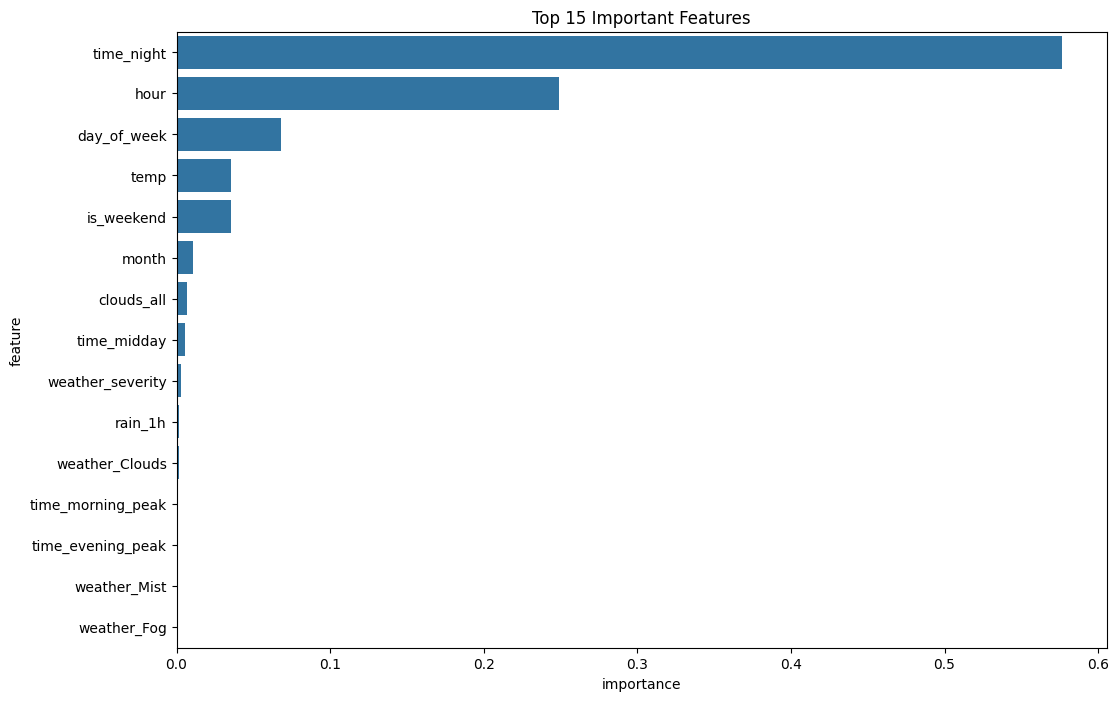

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Prepare data
X = df.drop('traffic_volume', axis=1)
y = df['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify no NaN values in training data
print("NaN values in X_train:", X_train.isnull().sum().sum())
print("NaN values in y_train:", y_train.isnull().sum())

# Models to try with proper NaN handling
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

# Evaluate each model with proper pipeline
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle any potential NaN values
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'model': pipeline
    }

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

# Select best model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Feature importance for tree-based models
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    importances = best_model.named_steps['model'].feature_importances_
    features = X.columns
    feature_importance = pd.DataFrame({'feature': features, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12,8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title('Top 15 Important Features')
    plt.show()

**4. Model Saving**

In [ ]:
import joblib

# Save the best model with the complete pipeline
joblib.dump(best_model, 'traffic_model.pkl')

# Save the column names for later use in the API
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("Model and columns saved successfully.")

Model and columns saved successfully.


**Deploying the Traffic Prediction System**

In [ ]:
# Traffic Prediction Deployment in Colab

# 1. Install dependencies
!pip install flask-ngrok pyngrok pandas scikit-learn joblib numpy

# 2. Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# 3. Get ngrok authtoken (sign up at ngrok.com)
!ngrok authtoken YOUR_TOKEN_HERE

# 4. Set up Flask app
from flask import Flask, request, jsonify, send_from_directory
from flask_ngrok import run_with_ngrok
import joblib
import pandas as pd
import numpy as np
import os

app = Flask(__name__, static_folder='.')
run_with_ngrok(app)

# Load model (upload these files first)
model = joblib.load('traffic_model.pkl')
model_columns = joblib.load('model_columns.pkl')

@app.route('/')
def home():
    return send_from_directory('.', 'index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        input_data = request.json
        input_df = pd.DataFrame([input_data])

        for col in model_columns:
            if col not in input_df:
                input_df[col] = 0

        input_df = input_df[model_columns]
        prediction = model.predict(input_df)

        return jsonify({'predicted_traffic_volume': float(prediction[0])})
    except Exception as e:
        return jsonify({'error': str(e)})


Mounted at /content/drive
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


**Create and Display the Web Interface**

In [ ]:
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Traffic Volume Predictor</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            line-height: 1.6;
        }
        h1 {
            color: #2c3e50;
            text-align: center;
        }
        .form-group {
            margin-bottom: 15px;
        }
        label {
            display: block;
            margin-bottom: 5px;
            font-weight: bold;
            color: #34495e;
        }
        input, select {
            width: 100%;
            padding: 10px;
            border: 1px solid #bdc3c7;
            border-radius: 4px;
            font-size: 16px;
        }
        button {
            background-color: #3498db;
            color: white;
            padding: 12px 20px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
            width: 100%;
            margin-top: 10px;
        }
        button:hover {
            background-color: #2980b9;
        }
        #result {
            margin-top: 20px;
            padding: 15px;
            border-radius: 4px;
            display: none;
        }
        .prediction {
            background-color: #e8f4fc;
            border-left: 4px solid #3498db;
        }
        .error {
            background-color: #fde8e8;
            border-left: 4px solid #e74c3c;
        }
        .instructions {
            background-color: #f8f9fa;
            padding: 15px;
            border-radius: 4px;
            margin-bottom: 20px;
            border-left: 4px solid #2ecc71;
        }
    </style>
</head>
<body>
    <h1>Metro Interstate Traffic Volume Predictor</h1>

    <div class="instructions">
        <h3>How to use:</h3>
        <p>Fill in the weather and time information below to predict the expected traffic volume.</p>
    </div>

    <div class="form-group">
        <label for="temp">Temperature (°C):</label>
        <input type="number" id="temp" step="0.1" placeholder="e.g., 20.5" required>
    </div>

    <div class="form-group">
        <label for="rain_1h">Rain in last hour (mm):</label>
        <input type="number" id="rain_1h" step="0.1" value="0" min="0" required>
    </div>

    <div class="form-group">
        <label for="snow_1h">Snow in last hour (mm):</label>
        <input type="number" id="snow_1h" step="0.1" value="0" min="0" required>
    </div>

    <div class="form-group">
        <label for="clouds_all">Cloud coverage (%):</label>
        <input type="number" id="clouds_all" min="0" max="100" value="0" required>
    </div>

    <div class="form-group">
        <label for="hour">Hour of day (0-23):</label>
        <input type="number" id="hour" min="0" max="23" value="12" required>
    </div>

    <div class="form-group">
        <label for="is_holiday">Is it a holiday?</label>
        <select id="is_holiday" required>
            <option value="0">No</option>
            <option value="1">Yes</option>
        </select>
    </div>

    <div class="form-group">
        <label for="weather_main">Weather condition:</label>
        <select id="weather_main" required>
            <option value="Clear">Clear</option>
            <option value="Clouds">Clouds</option>
            <option value="Rain">Rain</option>
            <option value="Drizzle">Drizzle</option>
            <option value="Snow">Snow</option>
            <option value="Mist">Mist</option>
            <option value="Haze">Haze</option>
            <option value="Fog">Fog</option>
            <option value="Thunderstorm">Thunderstorm</option>
        </select>
    </div>

    <button onclick="predictTraffic()">Predict Traffic Volume</button>

    <div id="result"></div>

    <script>
        async function predictTraffic() {
            // Get the result div and clear previous content
            const resultDiv = document.getElementById('result');
            resultDiv.style.display = 'none';
            resultDiv.className = '';

            // Validate inputs
            const temp = parseFloat(document.getElementById('temp').value);
            const rain_1h = parseFloat(document.getElementById('rain_1h').value);
            const snow_1h = parseFloat(document.getElementById('snow_1h').value);
            const clouds_all = parseInt(document.getElementById('clouds_all').value);
            const hour = parseInt(document.getElementById('hour').value);
            const is_holiday = parseInt(document.getElementById('is_holiday').value);
            const weather_main = document.getElementById('weather_main').value;

            // Simple validation
            if (isNaN(temp) || isNaN(rain_1h) || isNaN(snow_1h) || isNaN(clouds_all) || isNaN(hour)) {
                resultDiv.textContent = "Please fill in all fields with valid numbers";
                resultDiv.className = 'error';
                resultDiv.style.display = 'block';
                return;
            }

            // Calculate derived features
            const day_of_week = new Date().getDay(); // Current day of week (0-6)
            const month = new Date().getMonth() + 1; // Current month (1-12)
            const is_weekend = (day_of_week >= 5) ? 1 : 0;

            // Determine time of day
            let time_of_day;
            if (5 <= hour && hour < 10) time_of_day = 'morning_peak';
            else if (10 <= hour && hour < 16) time_of_day = 'midday';
            else if (16 <= hour && hour < 20) time_of_day = 'evening_peak';
            else time_of_day = 'night';

            // Weather severity mapping
            const weather_severity_map = {
                'Clear': 1,
                'Clouds': 2,
                'Drizzle': 3,
                'Rain': 4,
                'Snow': 5,
                'Thunderstorm': 6,
                'Mist': 3,
                'Haze': 3,
                'Fog': 4
            };
            const weather_severity = weather_severity_map[weather_main];

            // Prepare input data
            const inputData = {
                temp: temp,
                rain_1h: rain_1h,
                snow_1h: snow_1h,
                clouds_all: clouds_all,
                hour: hour,
                day_of_week: day_of_week,
                month: month,
                is_weekend: is_weekend,
                is_holiday: is_holiday,
                weather_severity: weather_severity
            };

            // Set all time features
            const time_categories = ['morning_peak', 'midday', 'evening_peak', 'night'];
            time_categories.forEach(cat => {
                inputData[`time_${cat}`] = (cat === time_of_day) ? 1 : 0;
            });

            // Set all weather features
            const weather_categories = ['Clear', 'Clouds', 'Rain', 'Drizzle', 'Snow', 'Thunderstorm', 'Mist', 'Haze', 'Fog'];
            weather_categories.forEach(cat => {
                inputData[`weather_${cat}`] = (cat === weather_main) ? 1 : 0;
            });

            try {
                // Show loading state
                resultDiv.textContent = "Calculating prediction...";
                resultDiv.className = 'prediction';
                resultDiv.style.display = 'block';

                // Call the API
                const response = await fetch('http://localhost:5000/predict', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json',
                    },
                    body: JSON.stringify(inputData)
                });

                const result = await response.json();

                if (result.error) {
                    resultDiv.textContent = `Error: ${result.error}`;
                    resultDiv.className = 'error';
                } else {
                    const trafficVolume = Math.round(result.predicted_traffic_volume);
                    resultDiv.innerHTML = `
                        <h3>Prediction Result</h3>
                        <p>Predicted Traffic Volume: <strong>${trafficVolume.toLocaleString()}</strong> vehicles/hour</p>
                        <p>Based on:</p>
                        <ul>
                            <li>Temperature: ${temp}°C</li>
                            <li>Hour: ${hour}:00</li>
                            <li>Weather: ${weather_main}</li>
                            <li>${is_holiday ? 'Holiday' : 'Not a holiday'}</li>
                        </ul>
                    `;
                    resultDiv.className = 'prediction';
                }
                resultDiv.style.display = 'block';
            } catch (error) {
                resultDiv.textContent = `Error: ${error.message}`;
                resultDiv.className = 'error';
                resultDiv.style.display = 'block';
            }
        }
    </script>
</body>
</html>
"""
with open('index.html', 'w') as f:
    f.write(html_content)

In [ ]:
#Run the app
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.11/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
           

Conclusion: This model compares different algorithm to select the best one. Helps understand which factors most influence the traffic and using simple HTML form for manual prediction and is ready for cloud deployment.